In [1]:
import pandas as pd
import sqlite3
import numpy as np
import os
import urllib.request, ssl
from scipy.stats import ecdf, wasserstein_distance
import struct

import matplotlib.pyplot as plt
import seaborn as sns

def download_file(url, local_filename):
    # Create an SSL context that does not verify certificates
    context = ssl._create_unverified_context()
    # Open the URL with the context and read the content
    with urllib.request.urlopen(url, context=context) as response:
        content = response.read()
    # Write the content to the local file
    with open(local_filename, 'wb') as file:
        file.write(content)

# Path to the SQLite file
db_file = "df_complete.db"
if not ( os.path.exists(db_file) ):
    # Download Raw Data
    print("Downloading raw data ... This may take a while, file size is 41.17GB")
    download_file(url="https://zenodo.org/records/14590312/files/df_complete.db?download=1", local_filename=db_file)
    print("Download complete")

# Connect to the database
conn = sqlite3.connect(db_file)
# Name of the tables to read
table_name_ex1 = "table_ex1"
table_name_ex3 = "table_ex3"
# SQL query to filter rows where  - reference sample
query_ex1 = f"SELECT * FROM {table_name_ex1} WHERE sample = 0"
query_ex3 = f"SELECT * FROM {table_name_ex3} WHERE sample = 0"
# Process the query in chunks to handle large datasets
chunk_size = 100000  # Adjust chunk size as needed
# To collect all filtered chunks
filtered_data_ex1 = []; filtered_data_ex3 = []
for chunk in pd.read_sql(query_ex1, conn, chunksize=chunk_size):
    filtered_data_ex1.append(chunk)  # Append each filtered chunk
for chunk in pd.read_sql(query_ex3, conn, chunksize=chunk_size):
    filtered_data_ex3.append(chunk)  # Append each filtered chunk
# Combine all chunks into a single DataFrame
df_filtered_ex1 = pd.concat(filtered_data_ex1, ignore_index=True)
df_filtered_ex3 = pd.concat(filtered_data_ex3, ignore_index=True)

# Close the connection
conn.close()


In [2]:
# Columns starting with dist_ are the ones that need to be converted from binary to numpy.array
for col in df_filtered_ex1.columns:
    if col.startswith('dist_'):
        df_filtered_ex1[col] = df_filtered_ex1[col].apply(lambda x: np.array(struct.unpack(f'{len(x)//8}d', x)))
for col in df_filtered_ex3.columns:
    if col.startswith('dist_'):
        df_filtered_ex3[col] = df_filtered_ex3[col].apply(lambda x: np.array(struct.unpack(f'{len(x)//8}d', x)))

# Cell population - AUC

The area under the curve (AUC) of cell population over time provides insights into the dynamics of different cell types in the simulation. The AUC is calculated for each cell type (live and dead) to quantify their population changes throughout the experiment.

- **Tumor Live Cells**: The AUC for tumor live cells represents the total number of live tumor cells over time. This metric helps in understanding the growth and survival rate of tumor cells.
- **Motile Live Cells**: The AUC for motile live cells indicates the population dynamics of motile tumor cells, which are typically more invasive and can migrate.
- **Tumor Dead Cells**: The AUC for tumor dead cells shows the cumulative number of dead tumor cells, providing insights into the cell death rate.
- **Motile Dead Cells**: The AUC for motile dead cells reflects the death rate of motile tumor cells.


,time,replicate,tumor_live,motile_live,tumor_dead,motile_dead
2420,0.0,0,2000,0,0,0
2421,60.0,0,1976,49,53,4
2422,120.0,0,1897,91,86,10
2423,180.0,0,1810,148,123,12
2424,240.0,0,1733,195,158,14
...,...,...,...,...,...,...
2536,6960.0,0,2063,278,481,185
2537,7020.0,0,2060,281,476,188
2538,7080.0,0,2086,269,481,191
2539,7140.0,0,2090,273,486,191


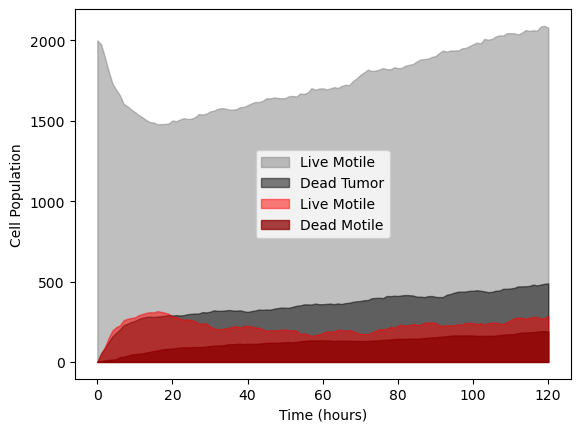

In [3]:
# Reference sample
df_ref1 = df_filtered_ex1[df_filtered_ex1['replicate'] == 0][['time', 'replicate', 'tumor_live', 'motile_live', 'tumor_dead', 'motile_dead']]

# Plotting AUC
fig, ax = plt.subplots()
ax.fill_between(df_ref1['time']/60.0, df_ref1['tumor_live'], 0, alpha=0.5, label='Live Motile', color='gray')
ax.fill_between(df_ref1['time']/60.0, df_ref1['tumor_dead'], 0, alpha=0.5, label='Dead Tumor', color='black')
ax.fill_between(df_ref1['time']/60.0, df_ref1['motile_live'], 0, alpha=0.5, label='Live Motile', color='red')
ax.fill_between(df_ref1['time']/60.0, df_ref1['motile_dead'], 0, alpha=0.75, label='Dead Motile', color='darkred')
ax.set(xlabel='Time (hours)', ylabel='Cell Population')
ax.legend()

fig.savefig('AUC_hypoxia.svg', format='svg')
df_ref1

# Cell Invasion - Distance from the Center (Last Snapshot)

## Distance from the Computational Center and Invasion Analysis

The distance from the computational center (0, 0, 0) for each cell type provides valuable insights into the spatial distribution and invasion dynamics of the cells. This analysis aids in understanding the extent of cell migration and invasion within the simulated environment.

### Cell Types and Distances
- **Tumor Live Cells**: The distances of live tumor cells from the center indicate their spread and potential for invasion into surrounding tissues.
- **Tumor Dead Cells**: The distances of dead tumor cells reveal regions where cell death is more prevalent.
- **Motile Live Cells**: The distances of motile live tumor cells are particularly important, as these cells are typically more invasive and capable of migrating farther from the center.
- **Motile Dead Cells**: The distances of dead motile tumor cells offer insights into areas where these invasive cells are more likely to succumb.

### Invasion Analysis
To examine invasion characteristics, we use the Wasserstein Distance to compare the spatial distributions of Tumor Live Cells and Motile Live Cells. This quantitative measure highlights differences in spatial distribution between these two cell types.


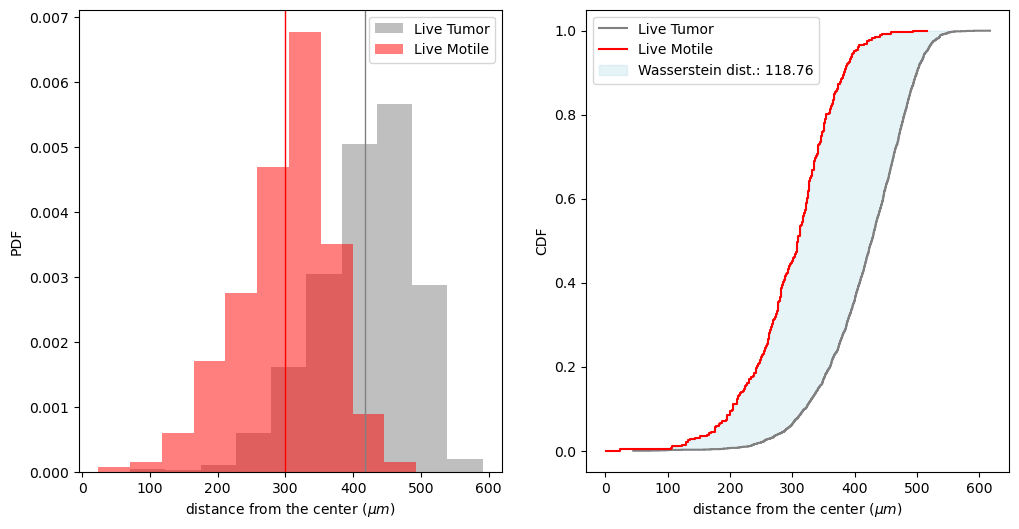

In [4]:
# Reference sample
df_ref1_dist = df_filtered_ex1[ (df_filtered_ex1['replicate'] == 0) & (df_filtered_ex1['time'] == 7200)][['time', 'replicate', 'dist_tumor_live', 'dist_motile_live']]
dist_tumor_live = df_ref1_dist['dist_tumor_live'].values[0]
dist_motile_live = df_ref1_dist['dist_motile_live'].values[0]
# Define empirical distributions of live cells
emp_liveTumor_cdf = ecdf(dist_tumor_live)
emp_liveMotile_cdf = ecdf(dist_motile_live)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot pdf approximations and means
pd.Series(dist_tumor_live).plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Live Tumor', color='gray')
pd.Series(dist_motile_live).plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Live Motile', color='red')
ax1.axvline(dist_tumor_live.mean(), color='gray', linestyle='solid', linewidth=1)
ax1.axvline(dist_motile_live.mean(), color='red', linestyle='solid', linewidth=1)
ax1_set = ax1.set(xlabel=r'distance from the center ($\mu m$)', ylabel='PDF')
ax1.legend()

# plot empirical cdf 
emp_liveTumor_cdf.cdf.plot(ax=ax2, label='Live Tumor', color='gray')
emp_liveMotile_cdf.cdf.plot(ax=ax2, label='Live Motile', color='red')
# plot the area between CDFs - Wasserstein distance
# interpolate emp_liveMotile_cdf to match the length of emp_liveTumor_cdf
interp_probabilities = np.interp(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.probabilities)
wassersteinDistance = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
ax2.fill_between(emp_liveTumor_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, interp_probabilities, alpha=0.3, interpolate=True,color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')

ax2_set = ax2.set(xlabel=r'distance from the center ($\mu m$)', ylabel='CDF')
ax2.legend()

plt.show()
fig.savefig('Wassertein_dist_hypoxia.svg', format='svg')

# Example 3: Simple tumor-immune model

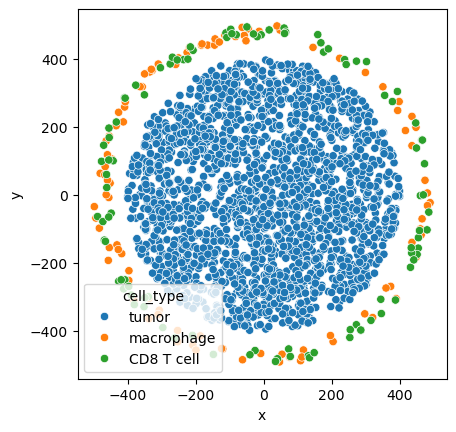

In [5]:
def initial_condition_random_annulus(fraction=1.0, fileName=None):
    # Set a new random seed each time to ensure different random numbers are generated
    np.random.seed()
    zval = 0;
    csv_array = np.empty((0, 4), dtype=[('x', 'float64'), ('y', 'float64'), ('z', 'float64'), ('cell_type', 'U20')])
    cell_types = {'tumor': 2000, 'macrophage': 100*fraction, 'CD8 T cell': 100*fraction}
    for cell_type in cell_types.keys():
        num_cells = cell_types[cell_type]
        count_cell = 0
        if cell_type == 'tumor':
            Radius_inner = 0
            Radius_external = 400
        else:
            Radius_inner = 450
            Radius_external = 500
        while count_cell < num_cells:
            t = 2.0 * np.pi * np.random.uniform() # theta ~ U(0,2pi)
            r = np.sqrt(np.random.uniform(Radius_inner**2, Radius_external**2))  # radius ~ sqrt(U(Radius_inner^2, Radius_external^2))
            xval = r * np.cos(t)
            yval = r * np.sin(t)
            # print(xval, yval, zval, cell_type)
            csv_array = np.append(csv_array, np.array([(xval, yval, zval, cell_type)], dtype=csv_array.dtype))
            count_cell += 1
    if fileName:
        header="x,y,z,type,volume,cycle entry,custom:GFP,custom:sample"
        np.savetxt(fileName, csv_array, header=header, delimiter=',', fmt='%.14f,%.14f,%f,%s', comments='')
    else:
        return csv_array
        
df_IC = pd.DataFrame(initial_condition_random_annulus(), columns=['x', 'y', 'z', 'cell_type'])
sns.scatterplot(x='x', y='y', hue='cell_type', data=df_IC)
plt.gca().set_aspect('equal', adjustable='box')

# AUC from reference parameter set

,time,replicate,tumor_live,tumor_apop,tumor_nec,macrophage,CD8 T cell,mac_pif_secretion,mac_aif_secretion
2420,0.0,0,2000,0,0,100,100,0.000000,10.000000
2421,60.0,0,2038,8,46,100,100,9.773193,0.226807
2422,120.0,0,1990,15,94,100,100,9.584533,0.415467
2423,180.0,0,1962,18,126,100,100,9.078753,0.921247
2424,240.0,0,1935,26,155,100,100,8.908330,1.091670
...,...,...,...,...,...,...,...,...,...
2536,6960.0,0,315,21,16,100,100,9.505817,0.494183
2537,7020.0,0,315,21,11,100,100,9.583229,0.416771
2538,7080.0,0,320,19,8,100,100,9.693336,0.306664
2539,7140.0,0,314,26,7,100,100,9.706437,0.293563


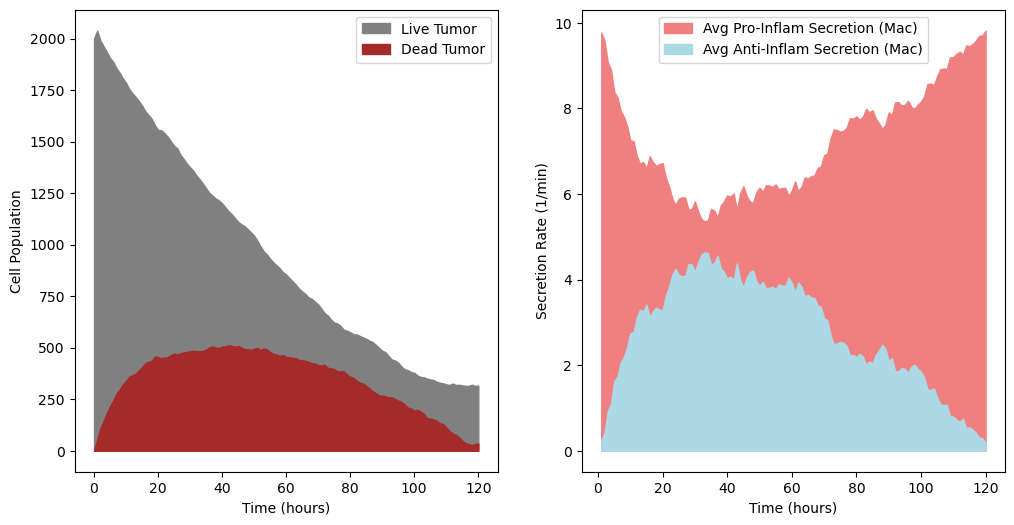

In [6]:
# Reference sample, mean across all replicates
df_ref3 = df_filtered_ex3[df_filtered_ex3['replicate'] == 0][['time', 'replicate', 'tumor_live', 'tumor_apop', 'tumor_nec', 'macrophage', 'CD8 T cell', 'mac_pif_secretion', 'mac_aif_secretion']]

# Plotting AUC
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
ax1.fill_between(df_ref3['time']/60.0, df_ref3['tumor_live'], 0, alpha=1, label='Live Tumor', color='gray')
ax1.fill_between(df_ref3['time']/60.0, df_ref3['tumor_nec']+df_ref3['tumor_apop'], 0, alpha=1, label='Dead Tumor', color='brown')
ax1.set(xlabel='Time (hours)', ylabel='Cell Population')
ax1.legend()
# Eliminate the time 0 point
ax2.fill_between(df_ref3['time'][1:]/60.0, df_ref3['mac_pif_secretion'][1:], 0, alpha=1, label='Avg Pro-Inflam Secretion (Mac)', color='lightcoral')
ax2.fill_between(df_ref3['time'][1:]/60.0, df_ref3['mac_aif_secretion'][1:], 0, alpha=1, label='Avg Anti-Inflam Secretion (Mac)', color='lightblue')
ax2.set(xlabel='Time (hours)', ylabel='Secretion Rate (1/min)')
ax2.legend()
fig.savefig('AUC_immune.svg', format='svg')
df_ref3

# Wassertein distances

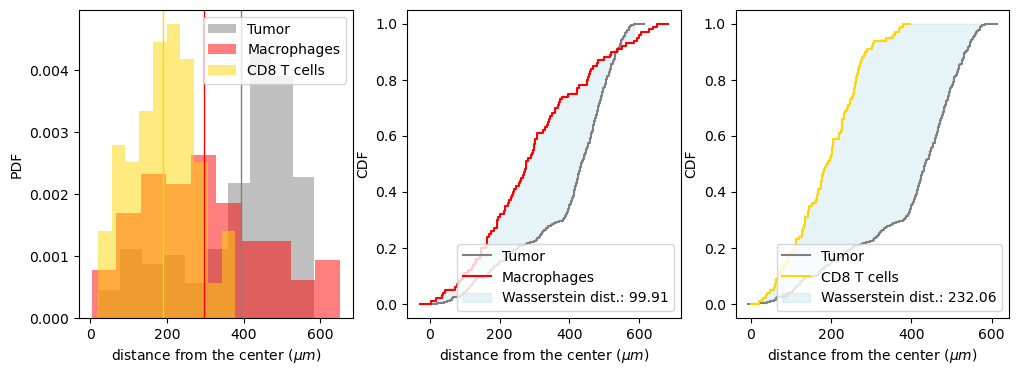

In [7]:
# Reference sample, mean across all replicates in the last point
df_ref3_dist = df_filtered_ex3[ (df_filtered_ex3['replicate'] == 0) & (df_filtered_ex3['time'] == 7200)][['time', 'replicate', 'dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec', 'dist_mac', 'dist_cd8']]
# Combine the three distributions of tumor cells - Tumor = Live + Apoptotic + Necrotic
df_ref3_dist['dist_tumor'] = df_ref3_dist.apply( lambda row: np.concatenate((row['dist_tumor_live'], row['dist_tumor_apop'], row['dist_tumor_nec'])), axis=1 )
df_ref3_dist = df_ref3_dist.drop(columns=['dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec'])
dist_tumor = df_ref3_dist['dist_tumor'].values[0]
dist_mac = df_ref3_dist['dist_mac'].values[0]
dist_cd8 = df_ref3_dist['dist_cd8'].values[0]
# Define empirical distributions of live cells
emp_Tumor_cdf = ecdf(dist_tumor)
emp_Mac_cdf = ecdf(dist_mac)
emp_CD8_cdf = ecdf(dist_cd8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# plot pdf approximations and means
pd.Series(dist_tumor).plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Tumor', color='gray')
pd.Series(dist_mac).plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Macrophages', color='red')
pd.Series(dist_cd8).plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='CD8 T cells', color='gold')
ax1.axvline(dist_tumor.mean(), color='gray', linestyle='solid', linewidth=1)
ax1.axvline(dist_mac.mean(), color='red', linestyle='solid', linewidth=1)
ax1.axvline(dist_cd8.mean(), color='gold', linestyle='solid', linewidth=1)
ax1_set = ax1.set(xlabel=r'distance from the center ($\mu m$)', ylabel='PDF')
ax1.legend()

# plot empirical cdf - tumor - macrophages
emp_Tumor_cdf.cdf.plot(ax=ax2, label='Tumor', color='gray')
emp_Mac_cdf.cdf.plot(ax=ax2, label='Macrophages', color='red')
# plot the area between CDFs - Wasserstein distance
wassersteinDistance = wasserstein_distance(emp_Tumor_cdf.cdf.quantiles, emp_Mac_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, emp_Mac_cdf.cdf.probabilities)
# interpolate emp_liveMotile_cdf to match the length of emp_liveTumor_cdf
interp_probabilities_mac = np.interp(emp_Tumor_cdf.cdf.quantiles, emp_Mac_cdf.cdf.quantiles, emp_Mac_cdf.cdf.probabilities)
# interpolate emp_Tumor_cdf to match the length of emp_CD8_cdf
interp_probabilities_tumor = np.interp(emp_Mac_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
# interp_probabilities_tumor = np.interp(emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
ax2.fill_between(emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, interp_probabilities_mac, alpha=0.3,
                 where=(emp_Tumor_cdf.cdf.quantiles > emp_Mac_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
ax2.fill_between(emp_Mac_cdf.cdf.quantiles, emp_Mac_cdf.cdf.probabilities, interp_probabilities_tumor, alpha=0.3,
                 where=(emp_Mac_cdf.cdf.quantiles < emp_Tumor_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue')

ax2_set = ax2.set(xlabel=r'distance from the center ($\mu m$)', ylabel='CDF')
ax2.legend()

# plot empirical cdf - tumor - CD8 T cells
emp_Tumor_cdf.cdf.plot(ax=ax3, label='Tumor', color='gray')
emp_CD8_cdf.cdf.plot(ax=ax3, label='CD8 T cells', color='gold')
# plot the area between CDFs - Wasserstein distance
wassersteinDistance = wasserstein_distance(emp_Tumor_cdf.cdf.quantiles, emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, emp_CD8_cdf.cdf.probabilities)
# interpolate emp_CD8_cdf to match the length of emp_Tumor_cdf
interp_probabilities_cd8 = np.interp(emp_Tumor_cdf.cdf.quantiles, emp_CD8_cdf.cdf.quantiles, emp_CD8_cdf.cdf.probabilities)
# interpolate emp_Tumor_cdf to match the length of emp_CD8_cdf
interp_probabilities_tumor = np.interp(emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
ax3.fill_between(emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, interp_probabilities_cd8, alpha=0.3,
                 where=(emp_Tumor_cdf.cdf.quantiles > emp_CD8_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
ax3.fill_between(emp_CD8_cdf.cdf.quantiles, emp_CD8_cdf.cdf.probabilities, interp_probabilities_tumor, alpha=0.3,
                 where=(emp_CD8_cdf.cdf.quantiles < emp_Tumor_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue')

ax3_set = ax3.set(xlabel=r'distance from the center ($\mu m$)', ylabel='CDF')
ax3.legend()

plt.show()
fig.savefig('Wassertein_dist_immune.svg', format='svg')